This section imports essential libraries required for the quantum machine learning model. Pennylane is used for quantum computations, TensorFlow for handling data and image processing, and other libraries for numerical operations and plotting.

In [1]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from pennylane.optimize import AdamOptimizer
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

This code checks whether a GPU is available for TensorFlow, which is important for optimizing performance. The output indicates that no GPU is detected.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Defines the file paths for the training and testing datasets, which are stored locally on the system.

In [3]:
dataset_path = '/Users/hannasav/downloads/qars/al5083'
train_image_dir = os.path.join(dataset_path, 'train')
test_image_dir = os.path.join(dataset_path, 'test')

This function that loads images from a specified directory, resizes them, converts them to grayscale, and stores them in a list along with their corresponding labels. Progress is tracked and displayed, and the function allows limiting the number of images loaded.

In [4]:
def load_images_from_folder(folder, img_size=(64, 64), limit=None):
    images = []
    labels = []
    total_files = sum([len(files) for r, d, files in os.walk(folder) if any(file.endswith(".png") for file in files)])
    processed_files = 0
    
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".png"):
                img_path = os.path.join(subdir, file)
                img = load_img(img_path, target_size=img_size, color_mode='grayscale')
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(subdir)
                processed_files += 1
                
                # Print progress
                print(f"Processed {processed_files}/{total_files} files ({(processed_files / total_files) * 100:.2f}%)")
                
                # Check if the limit has been reached
                if limit and processed_files >= limit:
                    print(f"Reached limit of {limit} images.")
                    break
        if limit and processed_files >= limit:
            break

    print("Loading images completed.")
    return np.array(images), np.array(labels)

Loads the training and testing datasets using the previously defined function. The test dataset is limited to 200 images. After loading, the images are normalized by dividing the pixel values by 255 to bring them within the [0, 1] range.

In [5]:
X_train_images, y_train_labels = load_images_from_folder(train_image_dir)
X_test_images, y_test_labels = load_images_from_folder(test_image_dir, limit=200)

X_train_images = X_train_images / 255.0
X_test_images = X_test_images / 255.0

Processed 1/26666 files (0.00%)
Processed 2/26666 files (0.01%)
Processed 3/26666 files (0.01%)
Processed 4/26666 files (0.02%)
Processed 5/26666 files (0.02%)
Processed 6/26666 files (0.02%)
Processed 7/26666 files (0.03%)
Processed 8/26666 files (0.03%)
Processed 9/26666 files (0.03%)
Processed 10/26666 files (0.04%)
Processed 11/26666 files (0.04%)
Processed 12/26666 files (0.05%)
Processed 13/26666 files (0.05%)
Processed 14/26666 files (0.05%)
Processed 15/26666 files (0.06%)
Processed 16/26666 files (0.06%)
Processed 17/26666 files (0.06%)
Processed 18/26666 files (0.07%)
Processed 19/26666 files (0.07%)
Processed 20/26666 files (0.08%)
Processed 21/26666 files (0.08%)
Processed 22/26666 files (0.08%)
Processed 23/26666 files (0.09%)
Processed 24/26666 files (0.09%)
Processed 25/26666 files (0.09%)
Processed 26/26666 files (0.10%)
Processed 27/26666 files (0.10%)
Processed 28/26666 files (0.11%)
Processed 29/26666 files (0.11%)
Processed 30/26666 files (0.11%)
Processed 31/26666 

In [6]:
print("Unique train labels:", np.unique(y_train_labels))
print("Unique test labels:", np.unique(y_test_labels))

Unique train labels: ['/Users/hannasav/downloads/qars/al5083/train/170815-133921-Al 2mm'
 '/Users/hannasav/downloads/qars/al5083/train/170815-134756-Al 2mm'
 '/Users/hannasav/downloads/qars/al5083/train/170904-112347-Al 2mm'
 '/Users/hannasav/downloads/qars/al5083/train/170904-113012-Al 2mm-part1'
 '/Users/hannasav/downloads/qars/al5083/train/170904-113012-Al 2mm-part2'
 '/Users/hannasav/downloads/qars/al5083/train/170904-115503-Al 2mm'
 '/Users/hannasav/downloads/qars/al5083/train/170904-115959-Al 2mm'
 '/Users/hannasav/downloads/qars/al5083/train/170904-141232-Al 2mm-part1'
 '/Users/hannasav/downloads/qars/al5083/train/170904-141232-Al 2mm-part2'
 '/Users/hannasav/downloads/qars/al5083/train/170904-141232-Al 2mm-part3'
 '/Users/hannasav/downloads/qars/al5083/train/170904-141730-Al 2mm-part1'
 '/Users/hannasav/downloads/qars/al5083/train/170904-141730-Al 2mm-part2'
 '/Users/hannasav/downloads/qars/al5083/train/170904-141730-Al 2mm-part3'
 '/Users/hannasav/downloads/qars/al5083/train/1

This block creates a mapping from the string-based labels to integer values, which are more suitable for model training. The labels are then converted from their string form to integers using this mapping.

In [7]:
all_labels = np.unique(np.concatenate((y_train_labels, y_test_labels)))
label_to_int = {label: idx for idx, label in enumerate(all_labels)}

print("Label to integer mapping:", label_to_int)

Label to integer mapping: {'/Users/hannasav/downloads/qars/al5083/test/170906-143512-Al 2mm-part1': 0, '/Users/hannasav/downloads/qars/al5083/test/170906-153326-Al 2mm-part3': 1, '/Users/hannasav/downloads/qars/al5083/train/170815-133921-Al 2mm': 2, '/Users/hannasav/downloads/qars/al5083/train/170815-134756-Al 2mm': 3, '/Users/hannasav/downloads/qars/al5083/train/170904-112347-Al 2mm': 4, '/Users/hannasav/downloads/qars/al5083/train/170904-113012-Al 2mm-part1': 5, '/Users/hannasav/downloads/qars/al5083/train/170904-113012-Al 2mm-part2': 6, '/Users/hannasav/downloads/qars/al5083/train/170904-115503-Al 2mm': 7, '/Users/hannasav/downloads/qars/al5083/train/170904-115959-Al 2mm': 8, '/Users/hannasav/downloads/qars/al5083/train/170904-141232-Al 2mm-part1': 9, '/Users/hannasav/downloads/qars/al5083/train/170904-141232-Al 2mm-part2': 10, '/Users/hannasav/downloads/qars/al5083/train/170904-141232-Al 2mm-part3': 11, '/Users/hannasav/downloads/qars/al5083/train/170904-141730-Al 2mm-part1': 12, '

The data is further split into training and testing subsets. Stratification is applied to ensure the label distribution remains balanced. The shapes of the resulting datasets are printed to verify correctness.

In [8]:
y_train_labels = np.array([label_to_int[label] for label in y_train_labels])
y_test_labels = np.array([label_to_int[label] for label in y_test_labels])

X_train_images, _, y_train_labels, _ = train_test_split(X_train_images, y_train_labels, train_size=0.8, stratify=y_train_labels, random_state=42)
X_test_images, _, y_test_labels, _ = train_test_split(X_test_images, y_test_labels, train_size=0.5, stratify=y_test_labels, random_state=42)

print(f"Training data shape: {X_train_images.shape}, Training labels shape: {y_train_labels.shape}")
print(f"Test data shape: {X_test_images.shape}, Test labels shape: {y_test_labels.shape}")

Training data shape: (21332, 64, 64, 1), Training labels shape: (21332,)
Test data shape: (100, 64, 64, 1), Test labels shape: (100,)


This function defines a quantum circuit block, which is composed of a CNOT gate and two RY rotation gates. These blocks are used to build more complex quantum circuits.

In [9]:
def block(weights, wires):
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])

This function to initialize the weights and biases for the quantum circuit. It generates random values for these parameters, which will later be optimized during training.

In [10]:
def init_weights(n_layers, n_wires, n_block_wires, n_params_block):
    n_blocks = qml.MERA.get_n_blocks(range(n_wires), n_block_wires)
    weights = np.random.random((n_layers, n_blocks, n_params_block))
    biases = np.random.random((n_layers, n_blocks))
    return weights, biases

Sets up the quantum device with the specified number of qubits (wires). The weights and biases are also initialized here using the previously defined function.

In [11]:
n_wires = 4
n_block_wires = 2
n_params_block = 2
weights, biases = init_weights(n_layers=2, n_wires=n_wires, n_block_wires=n_block_wires, n_params_block=n_params_block)

dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def circuit(weights, biases):
    for i, layer_weights in enumerate(weights):
        qml.MERA(range(n_wires), n_block_wires, block, n_params_block, layer_weights)
        for j in range(n_wires):
            qml.RX(biases[i][j], wires=j)  # Add bias as an RX rotation
    return qml.expval(qml.PauliZ(0))

result = circuit(weights, biases)
print("Result from the circuit:", result)

Result from the circuit: -0.5811243139846571


Defines the quantum circuit using the initialized quantum device. The circuit applies a MERA architecture and RX rotations based on the biases, and returns the expected value of the Pauli-Z measurement.

In [12]:
def qml_model(data, weights, biases):
    data_padded = np.pad(data, (0, max(0, n_wires - data.shape[0])), mode='constant')
    return circuit(weights, biases)

def loss(weights, biases, X, Y):
    predictions = [qml_model(x, weights, biases) for x in X]
    return np.mean((np.array(predictions) - Y) ** 2)

Executes the quantum circuit with the initialized weights and biases, printing the output to verify that it works correctly.

In [13]:
def init_weights(n_layers, n_wires, n_block_wires, n_params_block):
    n_blocks = qml.MERA.get_n_blocks(range(n_wires), n_block_wires)
    weights = np.random.normal(0, 0.1, (n_layers, n_blocks, n_params_block))  # Small random values
    biases = np.random.normal(0, 0.1, (n_layers, n_blocks))  # Small random biases
    return weights, biases

def flatten_params(weights, biases):
    return np.concatenate([weights.flatten(), biases.flatten()])

def unflatten_params(params, weights_shape, biases_shape):
    weights_size = np.prod(weights_shape)
    weights = params[:weights_size].reshape(weights_shape)
    biases = params[weights_size:].reshape(biases_shape)
    return weights, biases

def loss_fn(flat_params, X, Y, weights_shape, biases_shape):
    weights, biases = unflatten_params(flat_params, weights_shape, biases_shape)
    predictions = [qml_model(x, weights, biases) for x in X]
    return np.mean((np.array(predictions) - Y) ** 2)

Initializes the Adam optimizer with a specified learning rate for optimizing the model’s parameters.

The training loop iterates over the dataset for a specified number of epochs. During each iteration, the optimizer updates the parameters, and the loss is tracked and printed every 5 epochs. Reshapes the input data so that it is compatible with the quantum model, flattening the images to a single vector per image. Initializes the weights and biases, then starts the training process using the reshaped training data. Uses the trained model to make predictions on the test dataset, evaluating its performance.

In [14]:
opt = AdamOptimizer(0.001) 

def train(weights, biases, X, Y, epochs=10):
    flat_params = flatten_params(weights, biases)
    
    losses = []
    for epoch in range(epochs):
        flat_params, cost = opt.step_and_cost(lambda p: loss_fn(p, X, Y, weights.shape, biases.shape), flat_params)
        losses.append(cost)  # Track the loss
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch} - Loss: {cost:.4f}")
    
    trained_weights, trained_biases = unflatten_params(flat_params, weights.shape, biases.shape)
    return trained_weights, trained_biases, losses

In [15]:
X_train_flattened = X_train_images.reshape((X_train_images.shape[0], -1))
X_test_flattened = X_test_images.reshape((X_test_images.shape[0], -1))

weights, biases = init_weights(n_layers=2, n_wires=4, n_block_wires=2, n_params_block=2)

trained_weights, trained_biases, losses = train(weights, biases, X_train_flattened, y_train_labels)

test_preds = [qml_model(x, trained_weights, trained_biases) for x in X_test_flattened]

/opt/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 0 - Loss: 716.4354
Epoch 5 - Loss: 716.4354


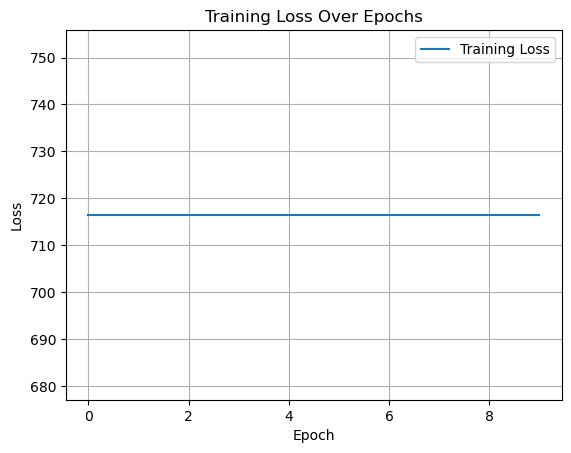

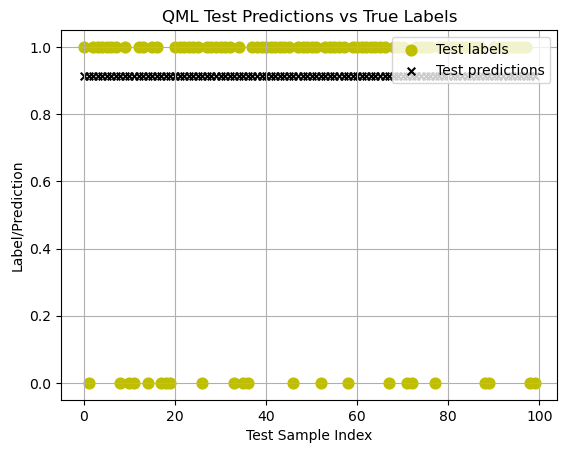

In [16]:
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Scatter plot for test predictions
plt.scatter(range(len(y_test_labels)), y_test_labels, s=60, c='y', marker="o", label='Test labels')
plt.scatter(range(len(test_preds)), test_preds, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Test Sample Index")
plt.ylabel("Label/Prediction")
plt.title("QML Test Predictions vs True Labels")
plt.legend(loc='upper right')
plt.grid()
plt.show()

Visualizes the input and output of the trained model using a few sample images. This helps in understanding how the model processes and represents the data.

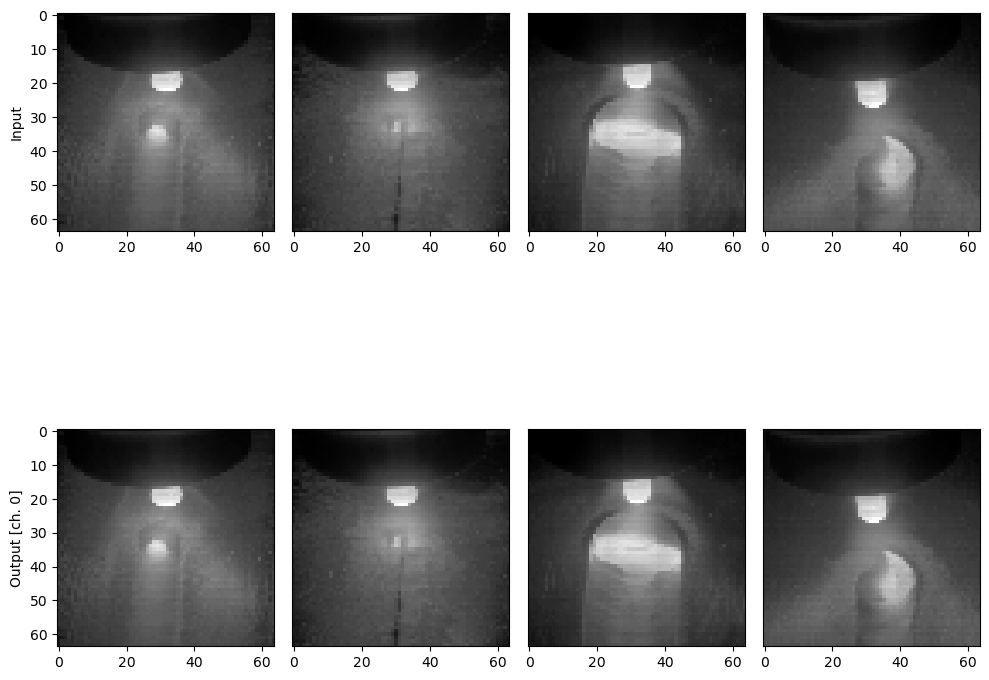

In [17]:
# Visualization of input and output using the trained model
n_samples = 4  
n_channels = 1  

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(X_train_images[k, :, :, 0], cmap="gray") 

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c + 1, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(X_train_images[k, :, :, 0], cmap="gray") 

plt.tight_layout()
plt.show()